<img src="escudo_utfsm.gif" style="float:right;height:100px">
<img src="IsotipoDIisocolor.png" style="float:left;height:100px">
<center>
    <h1> ILI285 - Computación Científica I / INF285 - Computación Científica</h1>
    <h1> New Tarea 3: Missing values  </h1>
    <h3> [S]cientific [C]omputing [T]eam 2019</h3>
</center>
<p>
<center>Agosto 2019 - v1.01 </center>
</p>

---

In [1]:
from __future__ import print_function
import numpy as np
#pip3 install imutils
import imutils
#pip3 install opencv-python
import cv2 
import scipy.interpolate as scp
import random
from timeit import default_timer
import math
import matplotlib.pyplot as plt


## Contexto

Luego de haber demostrado las habilidades de los estudiantes de Computación Científica en la tarea 1 y 2,
el SCT 2019 les encarga una nueva tarea: experimentar con métodos de interpolación 1D para rellenar _missing values_ en imagenes.

# Problema

Se desea rellenar un cuadrado, de lado $n$, de _missing values_ (valores _NaN_ perdidos de la imagen original) presentes en imagenes de diversos tipos usando interpolación en $1D$.

Suponga se tiene una imagen representada por una matriz de dimensiones $H$x$W$. Para un cuadrado de _missing values_ de tamaño $n < H,W$, donde la esquina superior izquierda del mismo está ubicado en la posición $(x_{hole}, y_{hole})$ de la matriz , se puede interpolar utilizando todos los valores distintos de _NaN_  de la fila $x_{hole}$ o columna $y_{hole}$ y utilizar el polinomio generado para rellenar los puntos que faltan de la misma fila/columna, y repetir este procedimiento para cada fila $i$ con $x_{hole} < i < x_{hole} + n$, o para cada columna $j$ con $ y_{hole} < j < y_{hole} + n$, hasta rellenar todos los _missing values_. Para ilustrar lo anterior, considere que se tiene la siguiente imagen con _missing values_:

<img src="example_2.png" style="float:center;height:200px">

La idea es utilizar la información de los pixeles presentes en la imagen para encontrar una aproximación de los _missing values_, e insertarlos en la imagen. Esto se puede realizar _fila a fila_ (tomando cada linea de pixeles horizontal y utilizar la _data_ presente para rellenar los _missing values_ de esa linea), _columna a columna_, o algún método híbrido entre ambos. El resultado ideal es el siguiente:

<img src="example_1.png" style="float:center;height:200px">

Para cargar una imagen a una matriz de tamaño _height_ x _width_, donde cada elemento $a_{ij}$ corresponde al código en escala de grises del pixel _ij_, puede usar la siguiente función. 

In [2]:
'''
src_name: path of the image.
'''
def image_to_matrix(src_name):
    # Se lee el video
    stream = cv2.imread(src_name,0)
    print("Tamanio imagen", stream.shape)
    return stream

def write_image(img, title):
    cv2.imwrite(title,img)
    
ej = image_to_matrix("example_1.png")
# organizada por columnas


Tamanio imagen (334, 500)


Por simplicidad de la dimensión de la matriz resultante, se cargaran las imagenes en escala de grises en lugar de usar colores. También se adjunta una función para escribir una matriz a una imagen de nombre _title_.

Para generar un cuadrado de _missing values_ en una posición aleatoria dentro de la imagen ya cargada, se usa la siguiente función.

In [3]:
'''
function to make a hole on the image matrix. 

image: array representation of image
size: size of the hole (>= 2)
seed: seed of the pseudo-random generator.
case: "center" for making a hole inside the image (default)
      "border" for making a hole on any border
      "corner" for making a hole on any corner

      
Returns a copy of the image with a hole, and the coordinates of the upper left corner of the hole
'''
def make_a_hole(image, size, seed, case="center"):
    random.seed(seed)
    h, w = image.shape
    if case == "center":
        x_hole,y_hole = random.randint(1, h - size - 1), random.randint(1, w - size - 1)
    elif case == "border":
        if random.choice([0,1]) == 0: 
            x_hole,y_hole = random.randint(1, h - size - 1), random.choice([0, w - size])
        else:
             x_hole,y_hole = random.choice([0, h - size]),random.randint(1, w - size - 1)
    elif case == "corner":
        position = random.choice([0,1,2,3]) 
        if position == 0:
            x_hole,y_hole = 0, 0
        elif position == 1:
            x_hole,y_hole = 0, w - size
        elif position == 2:
            x_hole,y_hole = h - size, 0
        elif position == 3:
            x_hole,y_hole = h - size, w - size
            
    aux = np.array(image,copy=True)
    aux[x_hole:x_hole+size, y_hole:y_hole+size] = np.nan
    
    return aux, x_hole,y_hole

### 1. Elección de método de interpolación

En primer lugar, se compararán diversos métodos de interpolación para interpolar y rellenar _missing values_. 

Encuentre, experimentalmente, la complejidad de la interpolación usando :
1. Método de Lagrange
2. Método de Lagrange Baricéntrico
3. _KroghInterpolator_ [1]
4. _CubicSpline_ [2]
5. _interp1d_ [3]
    
Para esto, realice un _log-log plot_ del **tiempo de cómputo de construcción del interpolador** para cada método _vs_ $n$ (tamaño del vector de la _data_ $(x,y)$, y encuentre la pendiente (orden del algoritmo) de la recta obtenida. Realice este análisis tomando un vector aleatorio $x$ de tamaño $n$ variable, donde $x_i \in [0,1]$, e interpole la función $f(x) = \sin(2\pi x)$ a modo de prueba, mediante un polinomio utilizando los métodos descritos anteriormente. Use la semilla propuesta a continuación.
    
 

In [4]:
random.seed(3)            
puntos = [[],[]]
N = 250

for i in range(N):
    x = random.random()
    puntos[0].append(x)

puntos[0].sort()
    
for j in range(N):
    y = np.sin(2*np.pi*puntos[0][j])
    puntos[1].append(y)

In [5]:
# Tiempos Lagrange

tiemposL = [] 

for j in range(10, N):
    start = default_timer()
    poly = scp.lagrange(puntos[0][0:j], puntos[1][0:j])
    tiemposL.append(default_timer()-start)
    #if j % 10 == 0: print(j)
#print(tiemposL)

In [6]:
# Tiempos Lagrange Baricentrica

tiemposB = []

for j in range(10,N):
    start = default_timer()
    poly = scp.BarycentricInterpolator(puntos[0][0:j], puntos[1][0:j])
    tiemposB.append(default_timer()-start)
    #if j % 10 == 0: print(j)
#print(tiemposB)

In [7]:
# Tiempos Kroghinterpolator

tiemposK = []

for j in range(10, N):
    start = default_timer()
    poly = scp.KroghInterpolator(puntos[0][0:j], puntos[1][0:j])
    tiemposK.append(default_timer()-start)
    #if j % 10 == 0: print(j)
#print(tiemposK)

In [8]:
# Tiempos CubiSpline

tiemposC = []

for j in range(10,N):
    start = default_timer()
    poly = scp.CubicSpline(puntos[0][0:j], puntos[1][0:j])
    tiemposC.append(default_timer()-start)
    #if j % 10 == 0: print(j)
#print(tiemposC)


In [9]:
# Tiempos interp1d

tiemposI = []

for j in range(10,N):
    start = default_timer()
    poly = scp.interp1d(puntos[0][0:j], puntos[1][0:j])
    tiemposI.append(default_timer()-start)
    #if j % 10 == 0: print(j)
#print(tiemposI)

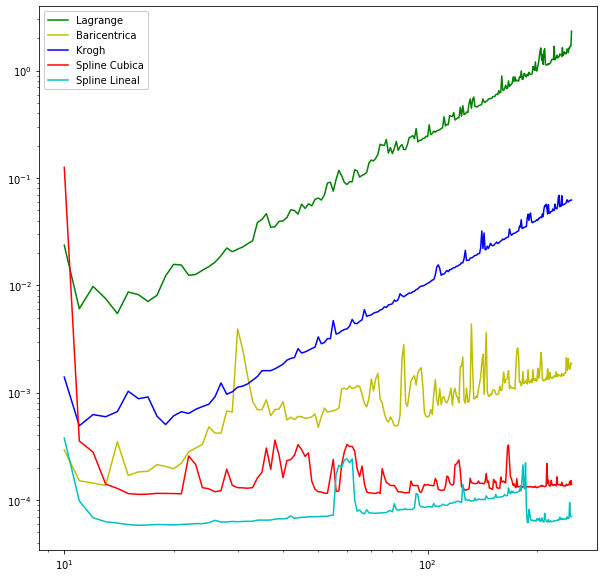

In [10]:
# LogLog plot

n = range(10,N)

fig= plt.figure(figsize=(10,10))
plt.loglog(n, tiemposL, 'g', label='Lagrange') 
plt.loglog(n, tiemposB, 'y', label='Baricentrica')
plt.loglog(n, tiemposK,  'b', label='Krogh')
plt.loglog(n, tiemposC, 'r', label='Spline Cubica')
plt.loglog(n, tiemposI, 'c', label='Spline Lineal')
plt.legend(framealpha=1, frameon=True);
plt.show()

   Grafique todas las curvas en el mismo plano para realizar la comparación. Concluya respecto al análisis anterior y, en base a esto, seleccione un método de interpolación adecuado para el resto de la tarea.

### 2. Elección de Heurística (Dirección de la interpolación)

Utilizando el método de interpolación seleccionado:

* Implemente la función `fill_hole_bidirectional` que rellene _missing values_ ordenados en un cuadrado de lado _size_ en una imagen utilizando interpolación vertical (es decir, rellenando columna a columna), interpolación horizontal (rellenando fila a fila), o del tipo _average_ (tomando el promedio de ambas interpolaciones). 


In [92]:
'''
function to fill a hole on the image matrix. 

image: array representation of image
x_hole,y_hole: coordinates of the hole
size: size of the hole (>= 2)
interpolator: function for interpolation.
direction: "h" for horizontal interpolation
            "v" for vertical interpolation
            "a" for average interpolation

'''

def fill_hole_bidirectional(image, x_hole, y_hole, size, interpolator, direction):
    height, width = image.shape
    
    if not(isinstance(size, int)) or size < 2:
        raise Exception("size must be an integer value >= 2. The value of size was: {}".format(size))
    
    # interpolacion horizontal
    if direction == 'h':
        xValues = [] 
        xValues.extend(range(0, y_hole))
        xValues.extend(range(y_hole + size, width))
        
        for j in range(x_hole, x_hole + size):
            
            yValues = []
            
            for i in range(0, y_hole):
                
                yValues.append(image[j][i])
            
            for i in range(y_hole + size, width):
                
                yValues.append(image[j][i])
            
            poly = interpolator(xValues, yValues)
            for i in range(y_hole, y_hole + size):
                image[j][i] = poly(i)
    
    # interpolacion vertical
    elif direction == 'v':
        xValues = [] 
        xValues.extend(range(0, x_hole))
        xValues.extend(range(x_hole + size, height))
        
        for i in range(y_hole, y_hole + size):
            yValues = []
            
            for j in range(0, x_hole):
                yValues.append(image[j][i])
                
            for j in range(x_hole + size, height):
                yValues.append(image[j][i])
            
            poly = interpolator(xValues, yValues)
            for j in range(x_hole, x_hole + size):
                image[j][i] = poly(j)
    
    # promedio entre ambas interpolaciones
    elif direction == 'a':
        # primer interpolacion horizontal
        for j in range(x_hole, x_hole + size):
            xValues = []
            yValues = []
            
            for i in range(0, y_hole):
                xValues.append(i)
                yValues.append(image[j][i])
            
            for i in range(y_hole + size, width):
                xValues.append(i)
                yValues.append(image[j][i])
            
            polyH = interpolator(xValues, yValues)
            for i in range(y_hole, y_hole + size):
                image[j][i] = polyH(i)/2
        
        # luego itnerpolacion vertical
        for i in range(y_hole, y_hole + size):
            xValues = []
            yValues = []
            
            for j in range(0, x_hole):
                xValues.append(j)
                yValues.append(image[j][i])
                
            for j in range(x_hole + size, height):
                xValues.append(j)
                yValues.append(image[j][i])
            
            polyV = interpolator(xValues, yValues)
            for j in range(x_hole, x_hole + size):
                image[j][i] += polyV(j)/2
    
                
    else:
        raise Exception("direction should either be 'h', 'v' or 'a'. The value of direction was: {}".format(direction))
    return image



In [93]:
# para probra el codigo
seed = random.seed(10)

# caso horizontal
ej1 = image_to_matrix("example_1.png")
ej11, x_hole1, y_hole1 = make_a_hole(ej1, 80, seed, case="center")
print(x_hole1, y_hole1)
write_image(ej11, 'ej11.png')

app1 = fill_hole_bidirectional(ej11, x_hole1, y_hole1, 80, scp.interp1d, 'h')
write_image(app1, 'app1.png')

# caso vertical

ej2 = image_to_matrix("example_1.png")
ej22, x_hole2, y_hole2 = make_a_hole(ej2, 80, seed, case="center")
print(x_hole2, y_hole2)
write_image(ej22, 'ej22.png')

app2 = fill_hole_bidirectional(ej22, x_hole2, y_hole2, 80, scp.interp1d, 'v')
write_image(app2, 'app2.png')

# caso promedio

ej3 = image_to_matrix("example_1.png")
ej33, x_hole3, y_hole3 = make_a_hole(ej3, 80, seed, case="center")
print(x_hole3, y_hole3)
write_image(ej33, 'ej33.png')

app3 = fill_hole_bidirectional(ej33, x_hole3, y_hole3, 80, scp.interp1d, 'a')
write_image(app3, 'app3.png')

Tamanio imagen (334, 500)
235 178
Tamanio imagen (334, 500)
44 310
Tamanio imagen (334, 500)
230 302


* Realice los siguientes tests:
  * Test de Rendimiento: Tiempo de cómputo del algoritmo
  * Test de Calidad de la interpolación resultante (Error matricial): Norma de Frobenius del error; es decir, sea $I$ la sección cuadrada $[x_{hole}, y_{hole}] \times [x_{hole} + n, y_{hole} + n]$ de la imagen original (sin _missing values_), y $R$ la misma sección cuadrada de la imagen reconstruida/interpolada: 
  
  $$
  || I - R ||_2 = \sqrt{\sum_{i=1}^{n} \sum_{j=1}^{n} |I_{ij} - R_{ij} |^2}
  $$
  
  Usando las imagenes de gradientes _v_gradient.png_, _h_gradient.jpg_ y _d_gradient.png_ con los 3 tipos de interpolación mencionados (_horizontal_, _vertical_ y _average_). Considere que los _missing values_ están en el interior de la imagen, i.e centrales. Realice los análisis para cada imagen generada utilizando los parámetros siguientes para `make_a_hole`. Realice un análisis cualitativo, graficando las imagenes resultantes y comparandolas con la imagen original. Argumente y concluya, basandose en ecuaciones, la elección de uno de los 3 tipos de interpolación para estos casos. Incluya otro tipo de métrica de comparación si lo considera necesario.

In [132]:
#test with h_gradient, v_gradient and d_gradient.
image = image_to_matrix("imagenes/h_gradient.png")

img_center_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=30, case="center")
#... interpolation using fill_hole_bidirectional and analisis

Tamanio imagen (2000, 2400)


   

* Realice el mismo análisis anterior, pero rellenando _missing values_ presentes en los bordes de la imagen. Realice los análisis para cada imagen generada utilizando los parámetros siguientes para `make_a_hole`. Argumente y concluya, basandose en ecuaciones, la elección de uno de los 3 tipos de interpolación para estos casos. Incluya otro tipo de métrica de comparación si lo considera necesario.

In [133]:
#test with h_gradient, v_gradient and d_gradient.
image = image_to_matrix("imagenes/h_gradient.png")

img_top_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=30, case="border")
#... interpolation using fill_hole_bidirectional and analisis
img_right_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=100, case="border")
#... interpolation using fill_hole_bidirectional and analisis
img_left_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=1, case="border")
#... interpolation using fill_hole_bidirectional and analisis
img_bottom_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=99, case="border")

#... interpolation using fill_hole_bidirectional.

Tamanio imagen (2000, 2400)


* Realice el mismo análisis anterior, pero rellenando _missing values_ presentes en las esquinas de la imagen. Realice los análisis para cada imagen generada utilizando los parámetros siguientes para `make_a_hole`. Argumente y concluya, basandose en ecuaciones, la elección de uno de los 3 tipos de interpolación para estos casos. Incluya otro tipo de métrica de comparación si lo considera necesario.

In [134]:
#test with h_gradient, v_gradient and d_gradient.
image = image_to_matrix("imagenes/h_gradient.png")

img_bottom_left_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=30, case="corner")
#... interpolation using fill_hole_bidirectional and analisis
img_top_left_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=160, case="corner")
#... interpolation using fill_hole_bidirectional and analisis
img_top_right_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=1, case="corner")
#... interpolation using fill_hole_bidirectional and analisis
img_bottom_right_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=99, case="corner")

#... interpolation using fill_hole_bidirectional and analisis

Tamanio imagen (2000, 2400)


### 3. Caso general utilizando imagen real.

* Implemente la función `fill_any_hole` que rellene _missing values_ presentes en una imagen en cualquier posición (interior, en algún borde o esquina). 

In [135]:
'''
function to fill a hole on the image matrix. 

image: array representation of image
x_hole,y_hole: coordinates of the hole
size: size of the hole (>= 2)
interpolator: function for interpolation.
'''

def fill_any_hole(image, x_hole, y_hole, size, interpolator):
    return

* Interpole y rellene _missing values_ ubicados en diversas posiciones en la imagen _ola.jpg_. Realice un análisis cualitativo y cuantitativo (graficando las imágenes y midiendo el error matricial respecto a la imagen sin _missing values_). Comente los resultados y concluya al respecto. 

In [136]:
image = image_to_matrix("imagenes/ola.jpg")
img_center_hole,x_hole,y_hole = make_a_hole(image, size=70, seed=30, case="center")
#... interpolation and analisis
img_border_hole,x_hole,y_hole = make_a_hole(image, size=70, seed=30, case="border")
#... interpolation and analisis
img_corner_hole,x_hole,y_hole = make_a_hole(image, size=70, seed=30, case="corner")
#... interpolation and analisis

Tamanio imagen (334, 500)


## Consideraciones Importantes

* Si bien se proveen los casos de prueba y las _seeds_ correspondientes, la revisión de la tarea puede ser realizada con otros casos de prueba y _seeds_ distintas, por lo que sus algoritmos deben funcionar para casos generales.

# Referencias
[1] Implementación de _scipy_ https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.KroghInterpolator.html#scipy.interpolate.KroghInterpolator

[2] Implementación de _scipy_ 
https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.CubicSpline.html

[3] Implementación de _scipy_ https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d

---
# Instrucciones:

* **Importante, Asegúrese de responder TODO lo que la pregunta pide.**
* La estructura de la tarea es la siguiente:
     1. Título, nombre de estudiante, email y rol.
     2. Responder cada pregunta de forma personal.
     5. Referencias. Es muy importante incluir todas las fuentes usadas, de otra forma se considera que lo no se ha citado adecuadamente es su trabajo.
* La tarea debe ser realizada en `Jupyter Notebook` (`Python3`) entregado.
* Recuerde responder la encuesta en el plazo establecido
* Se evaluará la correcta utilización de librerias `NumPy`, `SciPy`, `Matplotlib` y `ipywidgets`, entre otras, así como la **correcta implementación de algoritmos vectorizados**.
* **MUY IMPORTANTE** El archivo de entrega debe denominarse TareaN-rol.tar.gz y _notebook_ debe tener como nombre TareaN-rol.ipynb, donde $N$ es el número de la tarea y debe contener un directorio con todos los archivos necesarios para ejecutar el notebook, junto con un archivo README indicando explícitamente las librerías o módulos utilizados, nombre y rol del estudiante. Por cada error en este ambito implicará un descuento de 30 puntos.
* El descuento por día de atraso será de $30$ puntos, con un máximo de 1 día de atraso. No se recibirán entregas después de este día.
* Debe citar toda fuente de código externo. 
* El trabajo es personal, no se permite compartir código ni utilizar código de otros, aunque sí se sugiere discutir aspectos generales con sus compañeros.
* En caso de sospecha de no cumplimiento de estas instrucciones, se solicitará al involucrado o la involucrada a aclarar la situación. Dependiendo de la justificación se decidirá su calificación, la cual podrá o no ser penalizada.
* El no seguir estas instrucciones, implica descuentos en su nota obtenida.